# <font color='blue'> **Clasificación**
<font color='blue'> Tras haber analizado detenidamente la estructura de los datos en la fase de Visualización, vamos a diseñar una estrategia de Preprocesamiento para preparar los datos con los que vamos a entrenar los modelos. La idea es transformar los datos a una estructura que el algoritmo de clasificación acepte, al mismo que tiempo que maximice su capacidad de generalización. Tras ello, analizaremos los resultados y estudiaremos el rendimiento de los distintos modelos entrenados.

 ##  **1. Importar dataset**
 En primer lugar vamos a importar los tres archivos donde se encuentran nuestros datos. Cada uno posee una estructura distintas, por lo que tendremos que uniformizarlos.
A continuación combinaremos los tres datasets para formar nuestro corpus de correos spam.

In [135]:
#INSTALAR PAQUETES
#!pip install pandas
#!pip install wordcloud
#!pip install imbalanced-learn
#!pip install seaborn
#!pip install nltk

#IMPORTAR PAQUETES
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Lista predeterminada de palabras vacías en inglés
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Lista predeterminada de palabras vacías en inglés
import string
import re  #Biblioteca para utilizar expresiones regulares
import nltk #Biblioteca para técnicas de PLN
from nltk.tokenize import word_tokenize
nltk.download('punkt') #Datos para tokenizar
from imblearn.over_sampling import RandomOverSampler
from nltk import bigrams, trigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Leer los datos desde Google Drive**

In [137]:
'''
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
'''

"\n#Para acceder a nuestros ficheros de Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [138]:
'''
dataFolder = 'drive/MyDrive/Colab Notebooks/datos_tfg/'
data1 = pd.read_csv(dataFolder + "/enronSpamSubset.csv")
data2 = pd.read_csv(dataFolder + "/lingSpam.csv")
data3 = pd.read_csv(dataFolder + "/completeSpamAssassin.csv")
'''

'\ndataFolder = \'drive/MyDrive/Colab Notebooks/datos_tfg/\'\ndata1 = pd.read_csv(dataFolder + "/enronSpamSubset.csv")\ndata2 = pd.read_csv(dataFolder + "/lingSpam.csv")\ndata3 = pd.read_csv(dataFolder + "/completeSpamAssassin.csv")\n'

**Leer los datos desde el PC**

In [140]:
#Para leer desde el pc
data1=pd.read_csv("./deteccion_spam/datos/enronSpamSubset.csv")
data2=pd.read_csv("./deteccion_spam/datos/lingSpam.csv")
data3=pd.read_csv("./deteccion_spam/datos/completeSpamAssassin.csv")

## **2. Preprocesamiento**

Tras el análisis descriptivo y exploratorio del problema realizado en Visualizacion.ipynb, hemos comprendido mejor cómo se comportan nuestros datos. Ahora procedemos a la transformación de estos a una estructura que permita a los algoritmos de clasificación llegar a su máxima eficiencia.
Dicho preprocesamiento se divide en dos:
- **Limpieza y representación de los datos:** ya explicado detenidamente durante la fase de visualización
- **Transformación de los datos:** realizaremos una selección de características, un balanceo de clases y la vectorización de los términos en un formato aceptable para los algoritmos de clasificación que vamos a aplicar.

In [143]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  10000 non-null  int64 
 1   Unnamed: 0    10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


In [144]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2605 non-null   int64 
 1   Body        2605 non-null   object
 2   Label       2605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.2+ KB


In [145]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


Como los datos provienen de tres fuentes distintas, tenemos que uniformizar su estructura para que tengan únicamente 2 columnas: el cuerpo del mensaje (Body) y su etiqueta (Label).

In [147]:
#Quitamos para cada dataset las columnas irrelevantes
data1.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data2.drop("Unnamed: 0",inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

### **Limpieza y representación de los datos**

In [149]:
def limpieza(dataset):
    data = dataset.copy() #Creamos una copia explícita para evitar errores

    data.drop_duplicates(inplace=True)

    #Reemplazamos los espacios en blanco con NaN.
    #Usamos una expresión regular para reemplazar cualquier cadena que contenga únicamente espacios en blanco
    data['Body'] = data['Body'].replace(r'^\s*$', pd.NA, regex=True)

    # Eliminamos los correos con valores nulos
    data.dropna(subset=['Body'], inplace=True)

    # Quitamos mayúsculas
    data['Body'] = data['Body'].str.lower()

    # Reemplazamos las URLs por el token 'URL'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    data['Body'] = data['Body'].apply(lambda x: re.sub(url_pattern, 'URL', x))

    # Eliminamos signos de puntuación
    data['Body'] = data['Body'].str.replace(f'[{string.punctuation}]', ' ', regex=True)

    # Eliminamos todos los elementos que no sean caracteres alfabéticos (ya no necesitamos considerar los numéricos)
    #pattern = "[^a-zA-Z0-9]"
    pattern = "[^a-zA-Z ]"  # Espacio incluido para no eliminar los espacios entre palabras
    data['Body'] = data['Body'].apply(lambda x: re.sub(pattern, ' ', x))

    # Creamos una lista personalizada de palabras vacías
    stop_words_list = list(ENGLISH_STOP_WORDS)
    stop_words_list += ["subject"]

    # Eliminamos las stop words
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words_list]))

    # Eliminamos términos con longitud menor que 2
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

    return data

In [150]:
data1_clean=limpieza(data1)
data2_clean=limpieza(data2)
data3_clean=limpieza(data3)

A continuación concatenamos los tres Dataframes.

In [152]:

#Concatenar los tres dataframes
data_clean = pd.concat([data1_clean, data2_clean, data3_clean], ignore_index=True)

# Verificar la información del DataFrame
print(data_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17570 entries, 0 to 17569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    17570 non-null  object
 1   Label   17570 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 274.7+ KB
None


### **Selección de características**

Debido a que cuando vectoricemos el conjunto de datos, las características serán las palabras y los valores de estas la frecuencia en el correo, queremos quitar **características irrelevantes** eliminado las palabras cuya frecuencia total sea casi nula, pues no aportan gran cosa.

Realizamos esta selección antes que nada, pues al aplicar el balanceo de clases tendremos muchas más palabras y esto puede afectar al rendimiento, y también puede distorsionar la frecuencia real de los términos.

In [154]:
def seleccion_caracteristicas(data):
    #Contar frecuencia de cada palabra en todo el dataset
    all_words = ' '.join(data['Body']).split()
    word_freq = Counter(all_words)
    
    # Filtrar palabras con frecuencia menor que 5
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if word_freq[word] > 5]))

    #Mostramos las palabras después del filtrado
    all_words = ' '.join(data['Body']).split()
    word_freq = Counter(all_words)
    print(word_freq)
    
    return data

In [155]:
data=seleccion_caracteristicas(data_clean)

Counter({'enron': 17925, 'language': 17273, 'university': 17250, 'information': 14460, 'mail': 14021, 'com': 13704, 'new': 13114, 'URL': 12901, 'email': 11544, 'ect': 10993, 'time': 10289, 'list': 9239, 'linguistics': 8963, 'like': 8901, 'http': 8898, 'address': 8282, 'company': 8232, 'people': 8179, 'just': 8168, 'conference': 8148, 'free': 8129, 'use': 7667, 'make': 7351, 'business': 7285, 'www': 7241, 'order': 7098, 'papers': 6930, 'work': 6909, 'send': 6807, 'english': 6681, 'know': 6611, 'report': 6572, 'languages': 6526, 'money': 6418, 'program': 6378, 'fax': 6207, 'research': 6192, 'message': 5819, 'edu': 5776, 'need': 5588, 'number': 5502, 'hou': 5334, 'said': 5298, 'web': 5285, 'available': 5225, 'following': 5123, 'th': 5098, 'day': 4894, 'way': 4875, 'net': 4820, 'sent': 4780, 'contact': 4763, 'workshop': 4756, 'want': 4713, 'does': 4669, 'internet': 4640, 'world': 4580, 'based': 4551, 'data': 4520, 'software': 4502, 'pm': 4453, 'price': 4418, 'year': 4414, 'paper': 4304, 's

In [156]:
data

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu jun important inform...,1
3,utf life utf individual utf internal utf years...,1
4,bidstogo places things hello privacy policy pe...,1
...,...,...
17565,isilo tm palm os pocket pc windows enters beta...,0
17566,effector vol november ren eff orga publication...,0
17567,extended free seat sale thursday st november d...,0
17568,insignificant matters heavily hugh mt time imh...,0


### **Balanceo de clases**

En la fase de visualización vimos que las clases están bastante desbalanceadas. Para resolver este problema, vamos a aplicar **sobremuestreo**. Para ello, usaremos la función `RandomOverSampler` de la biblioteca `imbalanced-learn`. `RandomOverSampler` va replicando aleatoriamente las instancias de la clase minoritaria hasta alcanzar un equilibrio deseado.

In [158]:
#Función para visualizar la distribución de las clases (para ver si hay desbalanceo)
def distribucion(data, title):
    #Calculo la cantidad de correos electrónicos en cada clase
    class_distribution = data['Label'].value_counts()
    class_distribution = class_distribution.sort_index() #Simplemente para que la clase 0 aparezca primero

    # Visualizar la distribución de las clases
    plt.figure(figsize=(8, 6))
    class_distribution.plot(kind='bar', color= ['#45D2EB', '#FF5733'])
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Cantidad de Correos Electrónicos')
    plt.xticks(rotation=0)
    plt.show()

    print(class_distribution)

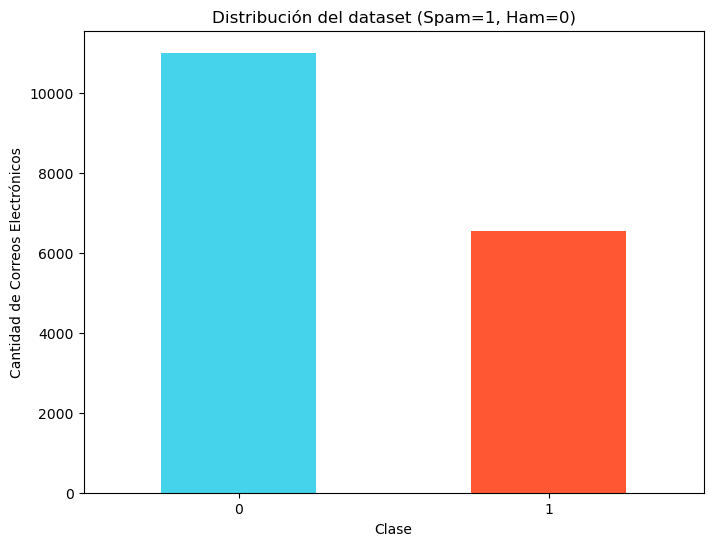

Label
0    11010
1     6560
Name: count, dtype: int64


In [159]:
distribucion(data, "Distribución del dataset (Spam=1, Ham=0)")

Observamos que hay casi el doble de instancias Ham que de Spam. Procedemos a aplicar sobremuestreo de la clase minoritaria.

In [161]:
def sobremuestreo(data):
    # Separamos las características y las etiquetas
    X = data.drop('Label', axis=1)  # características
    y = data['Label']  # etiquetas
    
    # Aplico el sobremuestreo
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = oversample.fit_resample(X, y)
    
    # Concatenamos las características y las etiquetas en un nuevo DataFrame
    data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)
    
    # Ahora 'data_resampled' contiene el conjunto de datos con clases balanceadas
    return data_resampled


In [162]:
data_resampled=sobremuestreo(data)

In [163]:
data_resampled

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu jun important inform...,1
3,utf life utf individual utf internal utf years...,1
4,bidstogo places things hello privacy policy pe...,1
...,...,...
22015,important requested file,1
22016,woman needs inch man man learn turn notificati...,1
22017,new capital fm want receive mails click follow...,1
22018,america companies compete business win today w...,1


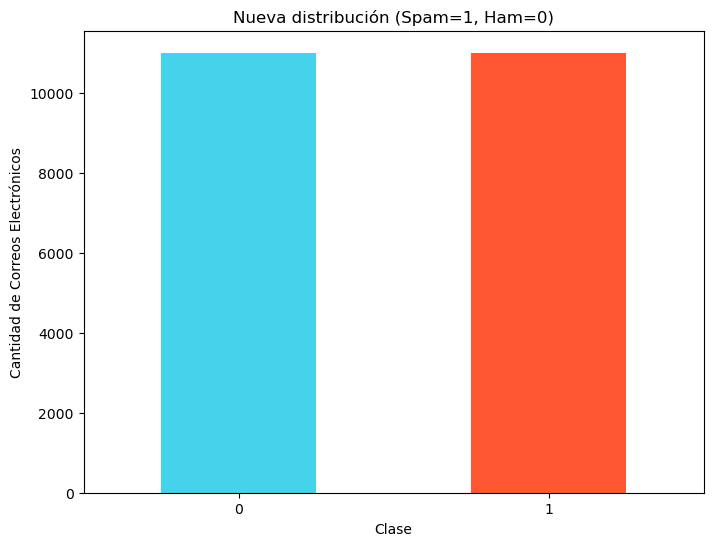

Label
0    11010
1    11010
Name: count, dtype: int64


In [164]:
distribucion(data_resampled, "Nueva distribución (Spam=1, Ham=0)")

### **División del conjunto de datos**

In [166]:
data=data_resampled

In [167]:
#Función para dividir el conjunto de datos en entrenamiento y prueba
def division_datos(data):
    X= data["Body"] #Atributos (sólo hay uno)
    y= data["Label"] #Etiquetas
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42) #Dividimos en conjunto de entrenamiento y de prueba (20% prueba)

    return X_train, X_test, y_train, y_test

In [168]:
X_train, X_test, y_train, y_test= division_datos(data)

### **Vectorización**

In [170]:
#Función para vectorizar el conjunto de datos
def vectorizacion(X_train, X_test, tipo):
    if tipo=="count":
        vectorizer=CountVectorizer(min_df=2) #Selección de características (eliminamos palabras con frecuencia 1)
    elif tipo=="tfidf":
        vectorizer=TfidfVectorizer(min_df=2)
    else:
        print("Error. Indica el tipo de vectorización: 'count' para CountVectorizer o 'tfidf' para TfidfVectorizer.")
        return
    X_train=vectorizer.fit_transform(X_train)
    X_test=vectorizer.transform(X_test)
    #print(vectorizer.vocabulary_)

    return X_train, X_test, vectorizer

In [171]:
X_train, X_test, vectorizer= vectorizacion(X_train, X_test, "count")

In [172]:
#Código en extinción
'''
import operator

# Obtener el vocabulario y sus recuentos de palabras
vocab = vectorizer.vocabulary_
word_counts = {word: X_train.getcol(idx).sum() for word, idx in vocab.items()}

# Ordenar el vocabulario por frecuencia de palabra (de mayor a menor)
sorted_vocab = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)

# Imprimir las palabras ordenadas por frecuencia
print("Palabras ordenadas por frecuencia:")
for word, count in sorted_vocab:
    print(word, count)
'''

'\nimport operator\n\n# Obtener el vocabulario y sus recuentos de palabras\nvocab = vectorizer.vocabulary_\nword_counts = {word: X_train.getcol(idx).sum() for word, idx in vocab.items()}\n\n# Ordenar el vocabulario por frecuencia de palabra (de mayor a menor)\nsorted_vocab = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)\n\n# Imprimir las palabras ordenadas por frecuencia\nprint("Palabras ordenadas por frecuencia:")\nfor word, count in sorted_vocab:\n    print(word, count)\n'

## **3. Búsqueda del mejor modelo**

En esta sección realizamos una **búsqueda de hiperparámetros** con el fin de encontrar los valores más óptimos para cada modelo. El problema principal que hemos encontrado es que, por ejemplo, para SVM, al tener tantas posibles combinaciones, y ser un algoritmo más complejo, tarda unas 2 horas en realizar la búsqueda.

- Para SVM usamos `RandomizedSearchCV` ya que tenemos muchos hiperparámetros y va a tardar una eternidad
- Para NBM usamos `GridSearchCV`

**Nota**: Fijamos una semilla `random_state=42` para siempre obtener los mismos resultados y no depender de la aleatoriedad.

### **Naive Bayes**

In [175]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

def NB_hiperparametros(X_train, y_train):
    #Definimos el método de validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    param_grid_NB = {
        'alpha': [1.0, 0.5, 0.2, 0.1, 0.01, 0.001, 0]  # Diferentes valores de alpha para probar
    }
    
    # Definición de GridSearchCV para Naive Bayes Multinomial
    grid_NB = GridSearchCV(MultinomialNB(), param_grid_NB, cv=cv, scoring='accuracy', verbose=2)
    
    #Ejecutamos la búsqueda de hiperparámetros
    grid_NB.fit(X_train, y_train)
    print(f"NB Multinomial best parameters: {grid_NB.best_params_}")
    print(f"NB Multinomial best CV accuracy: {grid_NB.best_score_}")

    return grid_NB.best_params_


In [176]:
#X_train, X_test, vectorizer= vectorizacion(X_train, X_test, "count")
best_params_NB=NB_hiperparametros(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ........................................

In [177]:
best_params_NB

{'alpha': 0.01}

### **SVM**

Debido al alto número de combinaciones de hiperparámetros de SVM, vamos a realizar la búsqueda de los mejores hiperparámetros con `RandomizedSearchCV`, el cual prueba `n_iter` combinaciones distintas y se queda con la mejor. 

In [179]:
from sklearn.svm import SVC

def SVM_hiperparametros(X_train, y_train):
    #Definimos el método de validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    param_grid_SVM = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1, 10],
        'kernel': ['rbf', 'linear', 'poly']
    }
    
    # Definición de GridSearchCV para SVM
    #grid_SVM = GridSearchCV(SVC(random_state=42), param_grid_SVM, cv=cv, scoring='accuracy', verbose=2)
    
    # Definición de RandomizedSearchCV para SVM
    grid_SVM = RandomizedSearchCV(SVC(random_state=42), param_grid_SVM, n_iter=10, cv=cv, scoring='accuracy', random_state=42, verbose=2)
    
    #Ejecutamos la búsqueda de hiperparámetros
    grid_SVM.fit(X_train, y_train)
    print(f"SVM best parameters: {grid_SVM.best_params_}")
    print(f"SVM best CV accuracy: {grid_SVM.best_score_}")

    return grid_SVM.best_params_


In [180]:
best_params_SVM=SVM_hiperparametros(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 8.5min


KeyboardInterrupt: 

#### **Resultados**
Observamos que las siguientes configuraciones de hiperparámetros son las que conducen a los mejores modelos:

In [ ]:
print(f"\nHiperparámetros del mejor modelo para Naive Bayes Multinomial: {best_params_NB}")
print(f"\nHiperparámetros del mejor modelo para SVM: {best_params_SVM}")

## **4. Entrenamiento y validación del mejor modelo**

El entrenamiento de modelos de Aprendizaje Automático y la estimación del error fuera de la muestra son cruciales para entender cómo los modelos generalizarán a instancias o datos nuevos, que no fueron considerados durante el entrenamiento. Este apartado aborda cómo se entrenaron los modelos, cómo se estimó el error fuera de la muestra y qué conclusiones podemos extraer de los resultados.


**Entrenamiento de los modelos**

Los modelos seleccionados fueron entrenados utilizando el conjunto de entrenamiento (`X_train`: espacio de características, `y_train`: etiquetas). Para cada modelo, se utilizaron los mejores hiperparámetros calculados mediante GridSearchCV, asegurando que cada modelo estuviera optimizado. El entrenamiento del modelo consiste en primer lugar en definir el objeto de validación cruzada, y pasarle el modelo declarado. Tras ello, con `model.fit` se entrena el modelo con el conjunto de entrenamiento dado. Así para cada uno de los tres modelos elegidos.


**Validación: Estimación del error fuera de la muestra**

El error fuera de la muestra se estima utilizando el conjunto de prueba (`X_test`, `y_test`). Esto proporciona una evaluación de cómo cada modelo realiza predicciones sobre datos que no fueron utilizados durante el entrenamiento, simulando cómo el modelo podría comportarse en situaciones del mundo real. La predicción se hace con el conjunto test dado, con `model.predict(X_test)`. Una vez obtenido el resultado de dicha predicción, `y_test_pred`, podemos calcular las medidas de evaluación y rendimiento.

In [ ]:
#Función que calcula las métricas de evaluación y rendimiento, dado y e y_pred
def metricas_evaluacion(y, y_pred, model_name):
  accuracy= accuracy_score(y, y_pred)
  precision= precision_score(y, y_pred, average='macro')
  recall= recall_score(y, y_pred, average='macro')
  f1= f1_score(y, y_pred, average='macro')
  conf_matrix=confusion_matrix(y, y_pred)
  class_report = classification_report(y, y_pred)

  #Mostramos por pantalla los resultados
  print(f"Resultados para {model_name}:")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("\nConfusion Matrix:\n", conf_matrix)
  print("\nClassification Report:\n", class_report)
  print("\n")

**NB Multinomial**

In [ ]:
def NB_validacion(parametros, X_train, y_train):
    name="NB Multinomial"
    
    #Reentrenamos los mejores modelos pero ahora sí con todo el conjunto de entrenamiento
    model = MultinomialNB(**parametros)
    model.fit(X_train, y_train)
    
    #for name, model in models.items():
    #Realizamos predicciones para el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    
    #Realizamos predicciones con el conjunto de prueba
    y_test_pred = model.predict(X_test)
    
    #Métricas de evaluación para la predicción del conjunto de entrenamiento y_train_pred
    print(f"--- Entrenamiento - {name} ({parametros})---")
    metricas_evaluacion(y_train, y_train_pred, name)
    
    #Métricas de evaluación para la predicción del conjunto de test y_test_pred
    print(f"--- Prueba - {name} ---")
    metricas_evaluacion(y_test, y_test_pred, name)
    
    return model

In [ ]:
model_NB=NB_validacion(best_params_NB, X_train, y_train)

#### **SVM**

In [ ]:
def SVM_validacion(parametros, X_train, y_train):
    name="SVM"
    
    #Reentrenamos el mejor modelo pero ahora sí con todo el conjunto de entrenamiento
    model = SVC(**parametros)
    model.fit(X_train, y_train)
    
    #Realizamos predicciones para el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    
    #Realizamos predicciones con el conjunto de prueba
    y_test_pred = model.predict(X_test)
    
    #Métricas de evaluación para la predicción del conjunto de entrenamiento y_train_pred
    print(f"--- Entrenamiento - {name} ({parametros})---")
    metricas_evaluacion(y_train, y_train_pred, name)
    
    #Métricas de evaluación para la predicción del conjunto de test y_test_pred
    print(f"--- Prueba - {name} ---")
    metricas_evaluacion(y_test, y_test_pred, name)
    
    return model

In [ ]:
model_SVM=SVM_validacion(best_params_SVM, X_train, y_train)

## **5. Otras representaciones: synsets**

### **Detección de hiperónimos en synsets**
Vamos a crear un dataset aparte, donde los términos sean obtenidos a partir de **synsets** de los términos originales. Usaremos los synsets del paquete WordNet de la librería NLTK.
De esta forma, estamos intentando agrupar términos que tienen relación. Por ejemplo, podemos observar que las palabras "dollar" y "euro" pertenecen a la misma categoría: "monetary_unit". De hecho no tiene sentido tratarlos como palabras completamente distintas, como lo harían nuestros algoritmos de clasificación sin este procesamiento.

A este nuevo dataset le aplicaremos todo el preprocesamiento anterior, y compararemos los resultados con el dataset si

In [ ]:
def obtener_primer_hiperonimo(palabra):
    #Obtenemos todos los synsets de la palabra
    synsets = wn.synsets(palabra)

    #Verificar si hay al menos un synset
    if synsets:
        #Seleccionamos el primer synset
        primer_synset = synsets[0]

        #Obtenemos los hiperónimos del primer synset
        hiperonimos = primer_synset.hypernyms()

        # Verificar si el synset tiene hiperónimos
        if hiperonimos:
            # Seleccionar el primer hiperónimo y obtener el primer lema
            primer_hiperonimo = hiperonimos[0].lemmas()[0].name()
            return primer_hiperonimo
        else:
            return palabra #No hay hiperónimos así que dejamos la palabra inicial
    else:
        return palabra #No hay synsets así que dejamos la palabra inicial

# Ejemplo de uso de la función
palabra = "dollar"
hiperonimo = obtener_primer_hiperonimo(palabra)
print(f"El primer hiperónimo de '{palabra}' es: {hiperonimo}")

palabra = "euro"
hiperonimo = obtener_primer_hiperonimo(palabra)
print(f"El primer hiperónimo de '{palabra}' es: {hiperonimo}")

In [ ]:
def reemplazar_con_hiperonimos(frase):
    palabras = frase.split()
    palabras_con_hiperonimos = [obtener_primer_hiperonimo(palabra) for palabra in palabras]
    frase_transformada = ' '.join(palabras_con_hiperonimos)
    return frase_transformada

In [ ]:
data_synsets=data_clean

In [ ]:
data_synsets['Body'] = data_synsets['Body'].apply(reemplazar_con_hiperonimos)

In [ ]:
data_synsets.head()

In [ ]:
data_synsets=seleccion_caracteristicas(data_synsets)

In [ ]:
X_train, X_test, y_train, y_test= division_datos(data_synsets)

In [ ]:
X_train, X_test, vectorizer= vectorizacion(X_train, X_test, "count")

**Realizamos los puntos 3 y 4 igual que antes**

In [ ]:
best_params_NB_synsets=NB_hiperparametros(X_train, y_train)

In [ ]:
best_params_SVM_synsets=SVM_hiperparametros(X_train, y_train)

In [ ]:
print(f"\nHiperparámetros del mejor modelo para Naive Bayes Multinomial: {best_params_NB_synsets}")
print(f"\nHiperparámetros del mejor modelo para SVM: {best_params_SVM_synsets}")

In [ ]:
model_NB_synsets=NB_validacion(best_params_NB_synsets, X_train, y_train)

In [ ]:
model_SVM_synsets=SVM_validacion(best_params_SVM_synsets, X_train, y_train)

## **6. Comparaciones**
Realizamos comparaciones entre los resultados obtenidos por los dos clasificadores (NB Multinomial y SVM), con las dos representaciones (términos o synsets) y con los dos tipos de vectorizaciones (CountVectorizer y TDIFVectorizer)